In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install keras tensorflow

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [31]:
data = pd.read_csv('usd_gbp20y.csv')

In [32]:
data['date'] = pd.to_datetime(data['date'])

In [33]:
data['dow'] = data.date.dt.dayofweek
data['day'] = data.date.dt.day

In [84]:
data.head(10)

,day,date,rate_open,rate_high,rate_low,rate_close,dow,rate_mid,idc,pidc,didc
6320,3.0,2000-01-03,1.614726,1.614466,1.639613,1.636126,0.0,0.61525,-0.0081,-1.307928,0
6319,4.0,2000-01-04,1.635858,1.631588,1.641228,1.636126,1.0,0.61125,-0.0001,-0.016359,0
6318,5.0,2000-01-05,1.637197,1.635323,1.645007,1.642576,2.0,0.60980,-0.0020,-0.327439,0
6317,6.0,2000-01-06,1.641767,1.641228,1.650982,1.647446,3.0,0.60805,-0.0021,-0.344771,0
6316,7.0,2000-01-07,1.647718,1.636126,1.649893,1.639344,4.0,0.60845,0.0031,0.510793,1
6314,10.0,2000-01-10,1.638807,1.633453,1.639882,1.637465,0.0,0.61045,0.0005,0.081940,1
6313,11.0,2000-01-11,1.636929,1.635056,1.649077,1.647446,1.0,0.60895,-0.0039,-0.638402,0
6312,12.0,2000-01-12,1.646904,1.645278,1.650710,1.646633,2.0,0.60725,0.0001,0.016469,1
6311,13.0,2000-01-13,1.647175,1.641228,1.649893,1.647175,3.0,0.60710,0.0000,0.000000,0
6310,14.0,2000-01-14,1.646904,1.631321,1.647989,1.631321,4.0,0.61010,0.0058,0.955204,1


In [35]:
data['rate_mid'] = (data['rate_open']+data['rate_close']) / 2
data["idc"] = data["rate_close"] - data["rate_open"]
data["pidc"] = (data["idc"] / data["rate_open"]) *100
data["didc"] = [1 if x > 0 else 0 for x in data['pidc']]

In [55]:
data = data.dropna()
data.head()

,day,date,rate_open,rate_high,rate_low,rate_close,dow,rate_mid,idc,pidc,didc
6320,3.0,2000-01-03,1.614726,1.614466,1.639613,1.636126,0.0,0.61525,-0.0081,-1.307928,0
6319,4.0,2000-01-04,1.635858,1.631588,1.641228,1.636126,1.0,0.61125,-0.0001,-0.016359,0
6318,5.0,2000-01-05,1.637197,1.635323,1.645007,1.642576,2.0,0.60980,-0.0020,-0.327439,0
6317,6.0,2000-01-06,1.641767,1.641228,1.650982,1.647446,3.0,0.60805,-0.0021,-0.344771,0
6316,7.0,2000-01-07,1.647718,1.636126,1.649893,1.639344,4.0,0.60845,0.0031,0.510793,1


In [37]:
data['rate_open'] = 1/data['rate_open']
data['rate_high'] = 1/data['rate_high']
data['rate_close'] = 1/data['rate_close']
data['rate_low'] = 1/data['rate_low']

In [38]:
data = data.iloc[::-1]

In [39]:
rate_open = data['rate_open'].values

In [40]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [189]:
def add_feature(features, original, data, split, timestep):
    initial = data[original].values
    train,test = initial[0:split], initial[split:]
    train = np.append(train,np.repeat(train[-1,],timestep))
    test = np.append(test,np.repeat(test[-1,],timestep))
    
    trainX1,trainY =convertToMatrix(train,timestep)
    testX1,testY =convertToMatrix(test,timestep)
    
    trainX = []
    testX = []
    for k,feature in enumerate(features):
        vals = data[feature].values
        train_add,test_add = vals[0:split], vals[split:]
        test_add = np.append(test_add,np.repeat(test_add[-1,],timestep))
        train_add = np.append(train_add,np.repeat(train_add[-1,],timestep))
        
        trainX2,trainY2 =convertToMatrix(train_add,timestep)
        testX2,testY2 =convertToMatrix(test_add,timestep)
        
        if len(trainX) == 0:
            for i in range(len(trainX2)):
                if i != split-1:
                    past = np.concatenate((trainX1[i], trainX2[i]))
                    today_open = [trainX2[i+1][-1]]
                    total = np.concatenate((past,today_open))
                    trainX += [total]
                else:
                    past = np.concatenate((trainX1[i], trainX2[i]))
                    today_open = [testX2[0][-1]]
                    total = np.concatenate((past,today_open))
                    trainX += [total]
                    
            for i in range(len(testX2)-1):
                past = np.concatenate((testX1[i], testX2[i]))
                today_open = [testX2[i+1][-1]]
                total = np.concatenate((past,today_open))         
                testX += [total]
            
        else:
            if k <= 1:
                for i,row in enumerate(trainX2):
                    trainX[i] = [np.concatenate((trainX[i], row))]
                for i in range(len(testX2)-1):
                    testX[i] = [np.concatenate((testX[i], testX2[i]))]   
            else:
                for i,row in enumerate(trainX2):
                    trainX[i] = [np.concatenate((trainX[i][0], row))]
                for i in range(len(testX2)-1):
                    testX[i] = [np.concatenate((testX[i][0], testX2[i]))]   

    trainX = np.array(trainX)
    testX = np.array(testX)
    if len(features) > 1:
        return trainX,testX,trainY,testY
    else:
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        return trainX,testX,trainY,testY[:-1]

In [198]:
trainX,testX,trainY,testY = add_feature(['rate_open','rate_high','rate_low'],'rate_close',data,4500,7)
testY=testY[:-1]

In [200]:
from keras.layers import Dense, SimpleRNN

In [201]:
model = Sequential()
model.add(LSTM(10, input_shape=(1,29), activation="relu"))#,batch_size=16,stateful=True))
model.add(Dense(10, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10)                1600      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 1,721
Trainable params: 1,721
Non-trainable params: 0
_________________________________________________________________


In [202]:
model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

Epoch 1/100
 - 1s - loss: 0.1114
Epoch 2/100
 - 1s - loss: 0.0011
Epoch 3/100
 - 1s - loss: 0.0011
Epoch 4/100
 - 1s - loss: 9.9158e-04
Epoch 5/100
 - 1s - loss: 9.1792e-04
Epoch 6/100
 - 1s - loss: 8.6930e-04
Epoch 7/100
 - 1s - loss: 8.3129e-04
Epoch 8/100
 - 1s - loss: 7.7996e-04
Epoch 9/100
 - 1s - loss: 7.7629e-04
Epoch 10/100
 - 1s - loss: 7.3718e-04
Epoch 11/100
 - 1s - loss: 7.3029e-04
Epoch 12/100
 - 1s - loss: 6.9843e-04
Epoch 13/100
 - 0s - loss: 7.0938e-04
Epoch 14/100
 - 0s - loss: 7.1274e-04
Epoch 15/100
 - 0s - loss: 6.8705e-04
Epoch 16/100
 - 0s - loss: 6.9839e-04
Epoch 17/100
 - 0s - loss: 6.8496e-04
Epoch 18/100
 - 0s - loss: 6.6914e-04
Epoch 19/100
 - 0s - loss: 6.7074e-04
Epoch 20/100
 - 0s - loss: 6.7175e-04
Epoch 21/100
 - 0s - loss: 6.5646e-04
Epoch 22/100
 - 1s - loss: 6.6026e-04
Epoch 23/100
 - 0s - loss: 6.3961e-04
Epoch 24/100
 - 1s - loss: 6.4113e-04
Epoch 25/100
 - 1s - loss: 6.6446e-04
Epoch 26/100
 - 1s - loss: 6.4699e-04
Epoch 27/100
 - 0s - loss: 6.4371

# Performance Evaluation 

In [203]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
testScore = model.evaluate(testX,testY,verbose=0)
print(trainScore)
print(testScore)

0.0002753035202848777
0.00010342121568527874


In [204]:
rate_close = data['rate_close'].values

In [205]:
def plot(start,end):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(rate_close[start:end],c='r')
    plt.plot(predicted[start:end],c='b')
    plt.show() 

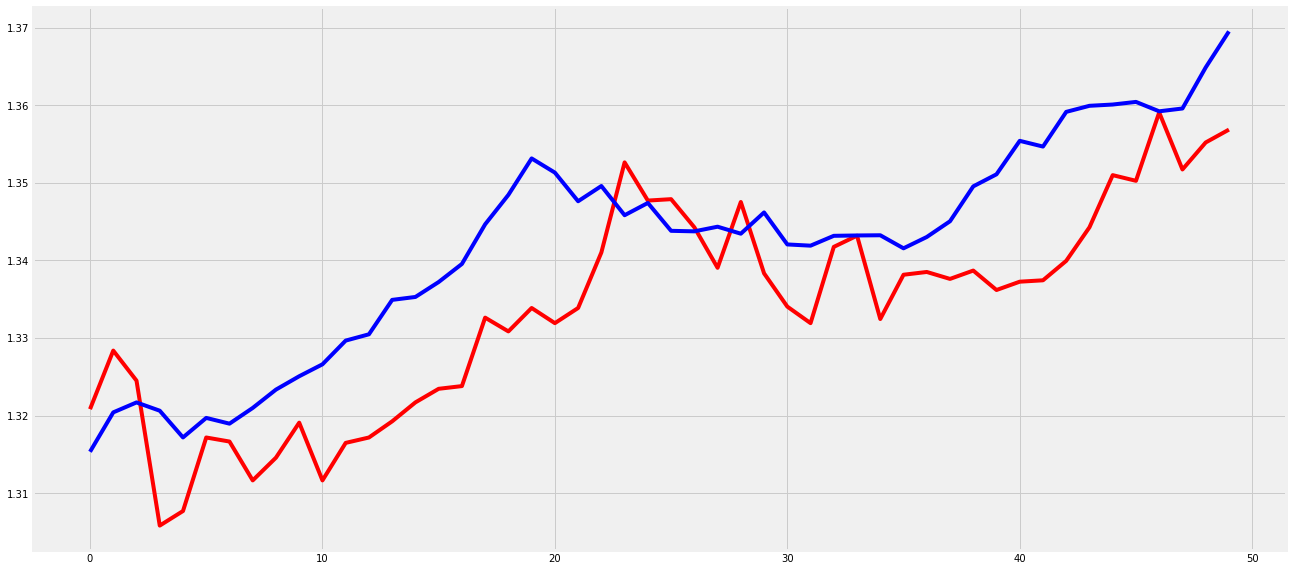

In [211]:
plot(4650,4700)